# Distance to Ust Ishim individual


Figure out if swept and non-swept haplotypes have a different relation to Ust Ishim individual


In [1]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy
import pandas
import scipy
from pandas import DataFrame, Series

numpy.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D 
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [4]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Import variables global to the entire analysis:

In [5]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [6]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [7]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

def bootstrap_se(sr, n=10000):
    means = list()
    for i in range(n):
        means.append(numpy.mean(sr.sample(frac=1, replace=True)))
    return numpy.std(means)

In [8]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))

## Load meta data

In [9]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load data for each individual

In [10]:
#all_male_indiv_dist = pandas.read_hdf(results_dir / 'all_male_indiv_dist.hdf')
sweep_data = (pandas.read_hdf(results_dir / 'sweep_data.hdf')
              .loc[lambda df: df.not_missing == True] # only include windows where enough individuals are called
             )
sweep_data.head()

,indiv_1,start,end,pop_1,region_label_1,region_id_1,region_1,mean_dist,mean_dist_af,mean_dist_to_africans,...,swept_af,not_missing,never_swept,never_swept_af,never_win_swept,never_win_swept_af,conserv_swept_group,conserv_swept_group_af,partial_sweep_win,partial_sweep_win_af
27,B_Australian-4,2700000,2800000,Australian,Oceania,4,Oceania,0.001051,0.001051,0.001735,...,False,True,True,True,True,True,no,no,False,False
28,B_Australian-4,2800000,2900000,Australian,Oceania,4,Oceania,0.000633,0.000623,0.001109,...,False,True,True,True,True,True,no,no,False,False
29,B_Australian-4,2900000,3000000,Australian,Oceania,4,Oceania,0.000377,0.000318,0.000844,...,False,True,True,True,False,False,no,no,False,False
30,B_Australian-4,3000000,3100000,Australian,Oceania,4,Oceania,0.001087,0.001087,0.001078,...,False,True,True,True,True,True,no,no,False,False
31,B_Australian-4,3100000,3200000,Australian,Oceania,4,Oceania,0.001212,0.001205,0.001544,...,False,True,True,True,True,True,no,no,False,False


## Build data frame with distances to Ust Ishim

Ust Ishim is indiv_2 in each pair.

In [11]:
def read_dist_table(file_name):

    col_names = ['chrom', 'start', 'end', 'pop_label',
                 'indiv_1', 'pseud_1', 'indiv_2', 'pseud_2',
                 'dist', 'mismatch', 'match',
                 'dist_af', 'mismatch_af', 'match_af',
                 'uncalled']
    
    with open(str(file_name), 'rb') as f:
        table = pickle.load(f)
    df = DataFrame(table, columns=col_names)
    df.indiv1 = [Path(x).name for x in df.indiv_1]
    df.indiv2 = [Path(x).name for x in df.indiv_2]
    return df

def indiv_filter(df):
    indiv1_in_meta = [x in individuals_and_ust_ishim for x in df.indiv_1]
    indiv2_in_meta = [x in individuals_and_ust_ishim for x in df.indiv_2]
    return([x and y for x, y in zip(indiv1_in_meta, indiv2_in_meta)])

def swap_indiv_to_put_ust_ishim_last(s1, s2):
    l = list()
    for indiv1, indiv2 in zip(s1, s2):
        if 'Ust_Ishim' in indiv1:
            l.append((indiv2, indiv1))
        else:
            l.append((indiv1, indiv2))
    return l

individuals_and_ust_ishim = set(list(individuals.keys()) + ['Ust_Ishim'])

In [12]:
dist_dir = steps_dir / 'male_x_haploid_dist_admix_masked'

ust_ishim_dist_data = (pandas.concat(map(read_dist_table, dist_dir.glob('*Ust_Ishim*'))) # read and concat pi tables
                    .loc[indiv_filter]
                    .reset_index(drop=True)
                    )

ust_ishim_dist_data['indiv_1'], ust_ishim_dist_data['indiv_2'] = \
    zip(*swap_indiv_to_put_ust_ishim_last(ust_ishim_dist_data['indiv_1'], ust_ishim_dist_data['indiv_2']))

ust_ishim_dist_data.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,match,dist_af,mismatch_af,match_af,uncalled
0,X,0,100000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.003014,4,1323,0.003014,4,1323,98673
1,X,100000,200000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.002703,10,3690,0.002703,10,3690,96300
2,X,200000,300000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.003673,22,5968,0.003673,22,5968,94010
3,X,300000,400000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.001955,24,12254,0.001955,24,12254,87722
4,X,400000,500000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.002232,16,7152,0.002232,16,7152,92832


Distribution of uncalled bases. We allow up to 80000 uncalled.

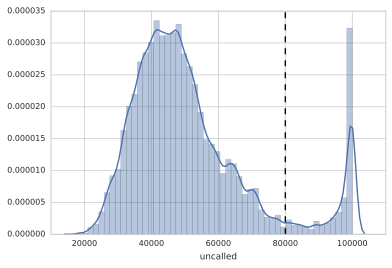

In [13]:
g = sns.distplot(ust_ishim_dist_data.uncalled)
g = g.axvline(80000, linestyle='dashed', color='black')

In [14]:
#ust_ishim_dist_data['dist'] = ust_ishim_dist_data['dist'].where(df.uncalled <= analysis_globals.max_uncalled_bases)
ust_ishim_dist_data = ust_ishim_dist_data.loc[lambda df: df.uncalled <= analysis_globals.max_uncalled_bases]
ust_ishim_dist_data.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,match,dist_af,mismatch_af,match_af,uncalled
39,X,3900000,4000000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000033,2,59941,0.000033,2,59941,40057
40,X,4000000,4100000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000017,1,57870,0.000017,1,57870,42129
42,X,4200000,4300000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000019,1,52425,0.000019,1,52425,47574
45,X,4500000,4600000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000053,3,57032,0.000053,3,57032,42965
51,X,5100000,5200000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000929,49,52703,0.000929,49,52703,47248


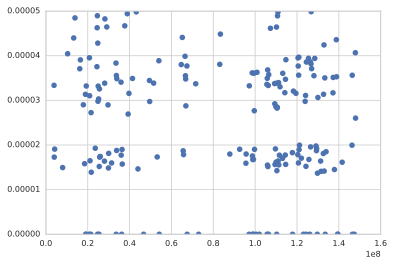

In [15]:
tmp = ust_ishim_dist_data.loc[(ust_ishim_dist_data.indiv_1 == 'S_Eskimo_Chaplin-1') & (ust_ishim_dist_data.dist < 5e-5), ['dist', 'start']] 
plt.plot(tmp.start, tmp.dist, 'o')


## Ust Ishim has a distribution of pairwise distances similar to other non-Africans

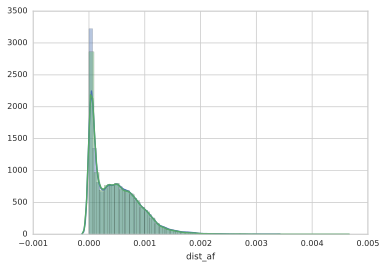

In [16]:
g = sns.distplot(ust_ishim_dist_data.dist)
g = sns.distplot(ust_ishim_dist_data.loc[lambda df: ~numpy.isnan(df.dist_af), 'dist_af'], ax=g)
#g.set_xlim(0, 0.002)

In [17]:
(~numpy.isnan(ust_ishim_dist_data.dist_af)).sum()

145222

## Call sweeps in Ust ishim

We scale our cut cutoff to take the Ust ishim sampel age into account:

In [18]:
BRANCH_SHORT = (60000 + (60000-45000)) / (2*60000)
BRANCH_SHORT * analysis_globals.pwdist_cutoff

3.125e-05

**Note:** the following two functions are copy/pasted from `nb_11_sweeps_from_male_dist_and_pi.ipynb`, but changed by substituting:

    analysis_globals.pwdist_cutoff

for

    BRANCH_SHORT * analysis_globals.pwdist_cutoff

In [19]:
def call_rolling_windows(df):#, pwdist_cutoff, min_sweep_clade_size):
    """
    Takes a df with all pwdiffs in a 500kb rolling window between 
    one indiv and all other individuals. Returns all nan if one or more 100kb 
    windows are without any data. Computes mean pwdist across 
    the five 100kb windows between each pair. Calls sweep_clade as number 
    of other indivisuals with a pwdist smaller than cutoff. Calls as
    swept if this number is above cutoff. Computes mean_clade_dist as 
    mean pwdist in sweep clade.
    """
    
    def mean_indiv_dist(df, col):
        """
        Compute mean across 100kb windows in in 500kb window.
        """
        if len(df) != nr_wins:
            return numpy.nan
        return df[col].mean()
    
    if numpy.isnan(df.groupby('start')['dist'].mean()).any():
        # one or more 100kb has no dist data
        called, clade_size, mean_clade_dist = numpy.nan, numpy.nan, numpy.nan
    else:
        # mean distance between indiv_1 and each indiv_2 for the 500kb window
        pwdiffs = df.groupby(['indiv_2']).apply(mean_indiv_dist, 'dist')

        mean_clade_dist = pwdiffs.loc[pwdiffs <= BRANCH_SHORT * analysis_globals.pwdist_cutoff].mean() 
        
        # number of indiv_2 closer to indiv_1 than cutoff across the 500kb window
        clade_size = (pwdiffs <= BRANCH_SHORT * analysis_globals.pwdist_cutoff).sum() 
        
        # call if clade size is larger then cutoff
        called = clade_size >= analysis_globals.min_sweep_clade_size
    
    if numpy.isnan(df.groupby('start')['dist_af'].mean()).any():     
        called_af, clade_size_af, mean_clade_dist_af = numpy.nan, numpy.nan, numpy.nan
    else:
        pwdiffs_af = df.groupby(['indiv_2']).apply(mean_indiv_dist, 'dist_af')

        mean_clade_dist_af = pwdiffs.loc[pwdiffs_af <= BRANCH_SHORT * analysis_globals.pwdist_cutoff].mean() 

        clade_size_af = (pwdiffs_af <= BRANCH_SHORT * analysis_globals.pwdist_cutoff).sum()

        called_af = clade_size_af >= analysis_globals.min_sweep_clade_size

    return df.copy().assign(called=called, clade_size=clade_size, mean_clade_dist=mean_clade_dist,
                            called_af=called_af, clade_size_af=clade_size_af, mean_clade_dist_af=mean_clade_dist_af)


def call_swept(df):
    """
    Takes a df with all rolling window data for an indivisual for one 100kb window.
    Call each 100kb window as sweept if any overlapping rolling window is called as swept.
    Compute clade size and mean clade dist as from the rolling window with the largest clade size.
    """
    max_clade_size = df.clade_size.max()
    max_clade_size_af = df.clade_size_af.max()
    
    largest_clade_offsets = (df.groupby('off')
                             .filter(lambda df: (df.clade_size == max_clade_size).all() and df.called.all())
                            )
    largest_clade_offsets_af = (df.groupby('off')
                             .filter(lambda df: (df.clade_size_af == max_clade_size_af).all() and df.called_af.all())
                            )
    return DataFrame(dict(called=[df.called.any()], 
                          clade_size=[max_clade_size],
                          clade_mean_dist=[largest_clade_offsets['dist'].mean()],
                          called_af=[df.called_af.any()], 
                          clade_size_af=[max_clade_size_af],
                          clade_mean_dist_af=[largest_clade_offsets_af['dist_af'].mean()]))

In [20]:
nr_wins = 5
offsets = [x * 100000 for x in range(nr_wins)]
window_size = len(offsets) * 100000

from multiprocessing import Pool, cpu_count

nr_cpu = int(os.environ.get('SLURM_JOB_NUM_NODES'))

lst = list()
# loop over five offsets of 500kb windows
for off in offsets:
    with Timer():
        print(off)
        groups = (ust_ishim_dist_data
                  .assign(off=off, # keep offset
                          roll_win = lambda df: (off + df.start) // window_size) # label for rolling 500kb window
                 .groupby(['indiv_1', 'roll_win', 'off'])
                 )
        with Pool(nr_cpu) as p:
            df = pandas.concat(p.map(call_rolling_windows, [group for name, group in groups]))

#        df = pandas.concat([call_rolling_windows(group) for name, group in groups])
            
        lst.append(df)

0
2 min 14.5 sec
100000
2 min 14.5 sec
200000
2 min 17.0 sec
300000
2 min 14.0 sec
400000
2 min 7.5 sec


In [21]:
with Timer():
    ust_ishim_sweep_calls = (pandas.concat(lst)
                   .groupby(['indiv_1', 'start'])
                   .apply(call_swept)
                   .reset_index(level=['indiv_1', 'start'])
                  )

25 min 52.9 sec


In [23]:
def run_id(sr):
    return (sr != sr.shift()).cumsum()

ust_ishim_sweep_calls['run_id'] = (ust_ishim_sweep_calls
                        .groupby('indiv_1')['called']
                        .apply(run_id)
                       )
ust_ishim_sweep_calls['run_length'] = (ust_ishim_sweep_calls
                            .groupby(['indiv_1', 'run_id'])['run_id']
                            .transform(numpy.size)
                           )
ust_ishim_sweep_calls['swept'] = numpy.bitwise_and(ust_ishim_sweep_calls['called'], 
                                        ust_ishim_sweep_calls['run_length'] >= analysis_globals.min_run_length)

In [24]:
ust_ishim_sweep_calls.called.sum()

0

Conclusion is that it is not possible to call sweeps as we do on non-Africans, likely due to either missing data or misscalled bases bringing dist above cutoff.

## Many extended sweep peaks are also swept in Ust Ishim

Get mean distance from swept individuals to Ust Ishim in each extended region.

We use the 90% extended regions and only those where enough individuals are included for us to call a sweep.

Very conservative due to many uncalled and admix filter. 

In [25]:
extended_peak_regions = (pandas.read_hdf(results_dir / 'extended_peak_regions_90%.hdf')
                         .loc[lambda df: df.prop_swept >= analysis_globals.min_prop_swept]
                        )
lst = list()
for tup in extended_peak_regions.itertuples():
    start = tup.start_pos
    end = tup.end_pos
    indivs = eval(tup.swept_indivs)
    
    # get distances between swept haplotypes and ust ishim
    df = ust_ishim_dist_data.copy().loc[lambda df: (df.start >= tup.start_pos) &\
                                        (df.end <= tup.end_pos) &\
                                        (df.indiv_1.isin(indivs))]
    df['peak_pos'] = tup.pos
#     lst.append(df[['peak_pos', 'dist', 'dist_af']])
    lst.append(df)

plot_df = pandas.concat(lst)

In [26]:
plot_df.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,match,dist_af,mismatch_af,match_af,uncalled,peak_pos
196,X,19600000,19700000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000354,23,64963,0.000354,23,64963,35014,19850000.0
197,X,19700000,19800000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000601,40,66559,0.000601,40,66559,33401,19850000.0
198,X,19800000,19900000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000358,21,58591,0.000358,21,58591,41388,19850000.0
199,X,19900000,20000000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000421,23,54641,0.000421,23,54641,45336,19850000.0
200,X,20000000,20100000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000384,23,59813,0.000384,23,59813,40164,19850000.0


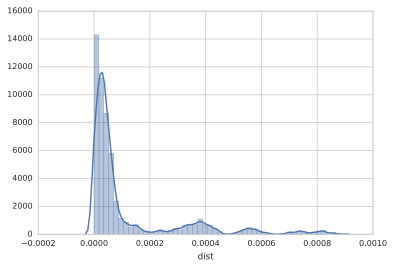

In [56]:
sns.distplot(plot_df.dist) ;

In [34]:
df = plot_df.groupby(['peak_pos', 'indiv_1'])[['dist', 'dist_af']].mean().reset_index()

mean_dists = df.loc[df.dist < 3.125e-5].groupby('peak_pos').filter(lambda df: len(df) >= 40).groupby('peak_pos').mean()
mean_dists

,dist,dist_af
peak_pos,,
21250000.0,0.000023,0.000023
36250000.0,0.000019,0.000019
54350000.0,0.000025,0.000025
98750000.0,0.000021,0.000021
114150000.0,0.000020,0.000020
127050000.0,0.000021,0.000021


In [58]:
# mean_dists = plot_df.groupby('peak_pos').mean()
# mean_dists

In [36]:

ust_ishim_extended_peak_regions = (mean_dists
 .reset_index()
 .merge(extended_peak_regions[['pos', 'start_pos', 'end_pos']],
       left_on=['peak_pos'], right_on=['pos'], how='left')
 .assign(length=lambda df: df.end_pos - df.start_pos)
 .drop(['pos', 'dist_af', ], axis=1)
 .assign(peak_pos=lambda df: df.peak_pos.astype(int))
 .sort_values(by='peak_pos')                                
)
ust_ishim_extended_peak_regions

,peak_pos,dist,start_pos,end_pos,length
0,21250000,0.000023,21100000,21600000,500000
1,36250000,0.000019,36000000,36400000,400000
2,54350000,0.000025,54000000,54400000,400000
3,98750000,0.000021,98500000,98900000,400000
4,114150000,0.000020,114000000,114300000,300000
5,127050000,0.000021,126800000,127400000,600000


In [61]:
ust_ishim_extended_peak_regions.to_csv(results_dir / 'ust_ishim_extended_peak_regions.csv', index=False)

In [38]:
plot_df = (df.groupby('peak_pos').mean()
 .reset_index()
 .merge(extended_peak_regions[['pos', 'start_pos', 'end_pos']],
       left_on=['peak_pos'], right_on=['pos'], how='left')
 .assign(length=lambda df: df.end_pos - df.start_pos)
 .drop(['pos', 'dist_af', ], axis=1)
 .assign(peak_pos=lambda df: df.peak_pos.astype(int))
 .sort_values(by='peak_pos')                                
)

In [39]:
plot_df

,peak_pos,dist,start_pos,end_pos,length
0,19850000,0.000409,19600000,20200000,600000
1,21250000,0.000028,21100000,21600000,500000
2,36250000,0.000022,36000000,36400000,400000
3,37500000,0.000697,37200000,37700000,500000
4,49900000,0.000065,49500000,50000000,500000
5,54350000,0.000034,54000000,54400000,400000
6,62950000,0.000160,62700000,63100000,400000
7,64850000,0.000042,64700000,65100000,400000
8,73200000,0.000065,73000000,73500000,500000
9,77150000,0.000271,76700000,77400000,700000


/home/kmt/anaconda2/envs/simons/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


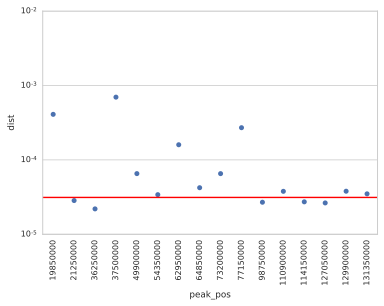

In [46]:
g = sns.pointplot(x='peak_pos', y='dist', data=plot_df, join=False, markers='.')
g = g.axhline(y=3.125e-5, color='red', linestyle='solid')
#plt.ylim(0,0.001)
plt.yscale("log")
plt.xticks(rotation=90) ;

This way we cannot call sweeps in Ust ishim, but only see how many of the sweeps we call include Ust ishim. I.e. the sweeps that Ust Ishim is part of. We decide they are if the mean distance of all swept individusla have a mean dist to Ust ishim that is lower than 5e-5.

In [49]:
# nr_ust_ishim_shared_sweeps = (mean_dists.dist <= 5e-5).sum()
# nr_ust_ishim_shared_sweeps_af = (mean_dists.dist_af <= 5e-5).sum()

# nr_ust_ishim_shared_sweeps, nr_ust_ishim_shared_sweeps_af

In [50]:
# print("All:", (mean_dists.dist <= 5e-5).sum() / len(mean_dists))
# print("Admix filt:", (mean_dists.dist_af <= 5e-5).sum() / len(mean_dists))

How many sweeps are each non-African part of? Count how many times each individual is part of a sweep:

In [51]:
from collections import Counter
lst = list()
for tup in extended_peak_regions.itertuples():
    indivs = eval(tup.swept_indivs)    
    lst.extend(indivs)
counts = Counter(lst)    

In [52]:
df = (DataFrame.from_records(((indiv, count, individuals[indiv]['Region']) for indiv, count in counts.items()),
                 columns=['indiv', 'nr_sweeps', 'region'])
      .loc[lambda df: df.region != 'Africa']
     )

Make sure we have all non-Africans analyzed:

In [53]:
len(df), len(sweep_data.loc[lambda df: df.region_1 != 'Africa'].indiv_1.unique())

(140, 140)

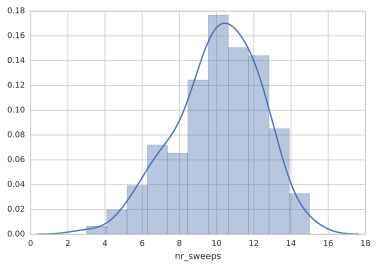

In [54]:
sns.distplot(df.nr_sweeps) ;

In [55]:
df.groupby('region').mean()

,nr_sweeps
region,
America,10.500000
CentralAsiaSiberia,11.000000
EastAsia,11.592593
Oceania,8.687500
SouthAsia,10.064516
WestEurasia,9.416667


Mean and SE of mean:

In [56]:
se = bootstrap_se(df.nr_sweeps)
print(df.nr_sweeps.mean(), df.nr_sweeps.mean()-1.96*se, df.nr_sweeps.mean()+1.96*se)

10.0714285714 9.70159445587 10.441262687


Quantiles of number of sweeps:

In [57]:
df.nr_sweeps.quantile(0.05), df.nr_sweeps.quantile(0.95)

(6.0, 13.0)

Total number of extended sweep regions:

In [58]:
tot_nr_extended_sweep_regions = len(extended_peak_regions.pos.unique())
tot_nr_extended_sweep_regions

16

In [59]:
nr_ust_ishim_shared_sweeps / tot_nr_extended_sweep_regions

0.375

# With which non-Africans does Ust Ishim share its inclusion in sweeps?

# The stuff below is irrelevant

Merge data:

In [34]:
merged_data = (ust_ishim_dist_data
           .merge(sweep_data[['indiv_1', 'start', 'region_1',
                              'swept', 'swept_af', # 'surely_not_swept', #'swept_in_region', 
                              'never_swept',  'never_swept_af', 
                              'partial_sweep_win', 'partial_sweep_win_af',
                              'never_win_swept', 'never_win_swept_af',
                              'conserv_swept_group', 'conserv_swept_group_af',
                              'mean_dist_to_africans', 'mean_dist_to_africans_af']], 
                  on=['indiv_1', 'start'], how='left')
           .loc[lambda df: df.region_1 != 'Africa']

          )
merged_data.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,...,never_swept,never_swept_af,partial_sweep_win,partial_sweep_win_af,never_win_swept,never_win_swept_af,conserv_swept_group,conserv_swept_group_af,mean_dist_to_africans,mean_dist_to_africans_af
0,X,3900000,4000000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000033,2,...,True,True,False,False,False,False,ambig,ambig,0.001707,0.001707
1,X,4000000,4100000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000017,1,...,True,True,False,False,False,False,no,no,0.000787,0.000787
2,X,4200000,4300000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000019,1,...,True,True,False,False,False,False,ambig,ambig,0.001188,0.001188
3,X,4500000,4600000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000053,3,...,True,True,False,False,True,False,no,no,0.000860,0.000860
4,X,5100000,5200000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000929,49,...,True,True,False,False,False,False,no,no,0.000941,0.000941


## Mean distance to Ust Ishim for swept and non-swept windows

              start           end  ust_ishim_dist
swept                                            
False  7.526473e+07  7.536473e+07         0.00034
True   7.526473e+07  7.536473e+07         0.00026

275 100kb chromosome windows
paired t-test pvalue: 4.66978814111e-06
mean reduction of swept: 0.170223459718


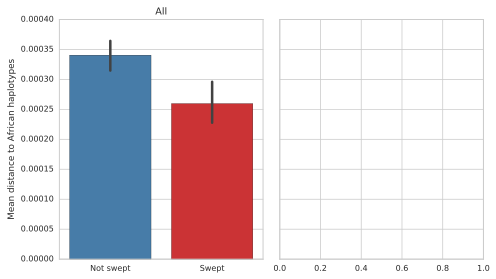

In [35]:
plot_df = (merged_data
#      .loc[lambda df: ~numpy.isnan(df.dist)]
      .loc[lambda df: (df.partial_sweep_win == True) & (df.conserv_swept_group != 'ambig')]
      .groupby(['start', 'end', 'swept'])['dist']
      .mean()
      .to_frame('ust_ishim_dist')
      .reset_index()
      # removing 'ambig' creates windows that does not have both swept and non-swept
      # so we need to filter to get only windows that include both calls:
      .groupby(['start']).filter(lambda df: set(df['swept']) == set([False, True]))
       )

print(plot_df.groupby('swept').mean())
swept = plot_df.sort_values(by='start').loc[lambda df: df['swept']==True, 'ust_ishim_dist']
non_swept = plot_df.sort_values(by='start').loc[lambda df: df['swept']==False, 'ust_ishim_dist']
pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
reduction = (non_swept.values-swept.values)/non_swept.values
print()
print(len(swept), '100kb chromosome windows')
print('paired t-test pvalue:', pval)
print('mean reduction of swept:', numpy.mean(reduction))

windows_without_swept_afr = (sweep_data
                             .groupby(['start'])
                             .filter(lambda df: ((df.swept == True) & (df.region_1 == 'Africa')).sum() == 0)
                             .loc[:, ['start', 'end']]
                             .drop_duplicates()
                            )

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), sharey=True)

            g1 = sns.barplot(x="swept", y="ust_ishim_dist", 
                             data=plot_df, 
                             ax=ax1, n_boot=1000)
#             ax1.set_title('All data used when evaluating\npairwise differences')
            ax1.set_title('All')
            ax1.set_ylabel('Mean distance to African haplotypes')
            ax1.set_xlabel('')
            ax1.set_xticklabels(['Not swept', 'Swept'])
            
#             ax1.set_xticklabels(['All data used when evaluating\npairwise differences', 'Admixture segments ignored\nwhen evaluating pairwise distances'])


            
#             g2 = sns.barplot(x="swept", y="ust_ishim_dist", 
#                              data=plot_df.merge(windows_without_swept_afr, on=['start', 'end']),
#                              ax=ax2, n_boot=1000)
#             ax2.set_title('Without windows where an African is also swept')
#             ax2.set_ylabel('Mean distance to African haplotypes')
#             ax2.set_xlabel('')
#             ax2.set_xticklabels(['Not swept', 'Swept'])
            
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'dist_to_afr.pdf' ))
            plt.savefig(str(figures_dir / 'dist_to_afr.png' ))

This plot is sort of beside the point, since we expect swept regions to be much closer if Ust Ishim are just another non-African with swept regions.

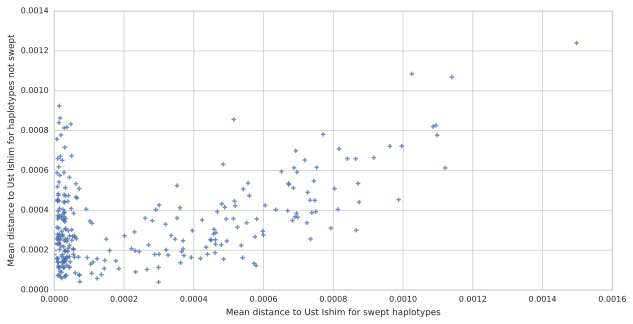

In [36]:
fig, ax = plt.subplots(1, figsize=(10, 5))
g = sns.regplot(x=swept, y=non_swept, fit_reg=False, marker="+")
g.set_xlim(xmin=0)
g.set_ylim(ymin=0)
g.set_xlabel('Mean distance to Ust Ishim for swept haplotypes')
g.set_ylabel('Mean distance to Ust Ishim for haplotypes not swept') ;

Looks like some swept haplotypes are shared (left vertical cloud) by Ust Ishim and that others are not (diagonal). Looks a lot like other other non-African individuals. Bacially says: Only some swept haplotypes are shared with Ust Ishim, suggesting that for some sweeps it was part of the sweep and for others it was not. However, the fact that *some* sweeps are shared, suggests that the sweeps happened between/during admixture and at most ~5000 years later.

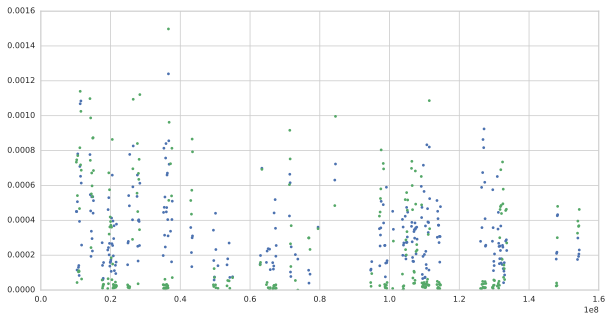

In [37]:
#sns.tsplot(time='start', value='ust_ishim_dist', condition='swept', data=plot_df)
#sns.pointplot(x='start', y='ust_ishim_dist', hue='swept', data=plot_df)
fig, ax = plt.subplots(1, figsize=(10, 5))
plt.plot(plot_df.loc[lambda df: df.swept == False].start, 
         plot_df.loc[lambda df: df.swept == False].ust_ishim_dist, 
         marker='.',
         linestyle = 'None'
         #'bo'
        )
plt.plot(plot_df.loc[lambda df: df.swept == True].start, 
         plot_df.loc[lambda df: df.swept == True].ust_ishim_dist, 
         marker='.',
         linestyle = 'None'
        # 'ro'
        )

In [38]:
plot_df.head()

,start,end,swept,ust_ishim_dist
0,10200000,10300000,False,0.000451
1,10200000,10300000,True,0.000734
2,10300000,10400000,False,0.000450
3,10300000,10400000,True,0.000747
4,10400000,10500000,False,0.000115


What proportion of chromosomal windows have a mean distance to Ust Ishim below pwdiff cutoff for swept and non-swept individuals:

In [39]:
(plot_df
 .groupby(['swept'])
 .apply(lambda df: sum(df.ust_ishim_dist <= analysis_globals.pwdist_cutoff) / len(df.ust_ishim_dist))
)

swept
False    0.007273
True     0.458182
dtype: float64

So 43% 100kb chormosomal windows, called sweeps include Ust Ishim (by the pwdiff cutoff criterion). By contrast, the distance to Ust Ishim only fall below the cutoff for 3.5% of windows.

In [40]:
merged_data.head()



,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,...,never_swept,never_swept_af,partial_sweep_win,partial_sweep_win_af,never_win_swept,never_win_swept_af,conserv_swept_group,conserv_swept_group_af,mean_dist_to_africans,mean_dist_to_africans_af
0,X,3900000,4000000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000033,2,...,True,True,False,False,False,False,ambig,ambig,0.001707,0.001707
1,X,4000000,4100000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000017,1,...,True,True,False,False,False,False,no,no,0.000787,0.000787
2,X,4200000,4300000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000019,1,...,True,True,False,False,False,False,ambig,ambig,0.001188,0.001188
3,X,4500000,4600000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000053,3,...,True,True,False,False,True,False,no,no,0.000860,0.000860
4,X,5100000,5200000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000929,49,...,True,True,False,False,False,False,no,no,0.000941,0.000941


See how long the sweeps shared with Ust Ishim are:

In [41]:
df = (plot_df
      .assign(is_in_clade = lambda df: (df.swept == True) & (df.ust_ishim_dist <= analysis_globals.pwdist_cutoff))
             )
df.head()

,start,end,swept,ust_ishim_dist,is_in_clade
0,10200000,10300000,False,0.000451,False
1,10200000,10300000,True,0.000734,False
2,10300000,10400000,False,0.000450,False
3,10300000,10400000,True,0.000747,False
4,10400000,10500000,False,0.000115,False


In [42]:
df['run_id'] = (df.is_in_clade != df.is_in_clade.shift()).cumsum()

df['run_length'] = df.groupby('run_id')['run_id'].transform(numpy.size)

_df = df.loc[lambda df: df.is_in_clade == True, ['run_length', 'start']].drop_duplicates()


In [43]:
df


,start,end,swept,ust_ishim_dist,is_in_clade,run_id,run_length
0,10200000,10300000,False,0.000451,False,1,5
1,10200000,10300000,True,0.000734,False,1,5
2,10300000,10400000,False,0.000450,False,1,5
3,10300000,10400000,True,0.000747,False,1,5
4,10400000,10500000,False,0.000115,False,1,5
5,10400000,10500000,True,0.000043,True,2,1
6,10500000,10600000,False,0.000507,False,3,49
7,10500000,10600000,True,0.000542,False,3,49
8,10600000,10700000,False,0.000781,False,3,49
9,10600000,10700000,True,0.000771,False,3,49


(array([   0.,  126.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

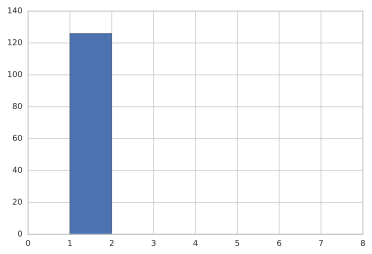

In [44]:
#plt.hist(df.loc[lambda df: df.is_in_clade == True, 'run_length'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8])
plt.hist(_df.run_length, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8])



# df['run_id'] = (df['is_in_clade']
#                         .apply(run_id)
#                        )
# df['run_length'] = (df['run_id']
#                             
#                            )

Someone might ask why we do not just call sweeps in Ust Ishim like in the extant non-Africans. This is because there is much more missing data in the Ust Ishim, because it is ancient, and because it has more and longer tracts of admixture. This would make it difficult to compare calls to extant individuals anyway.

Better to say we call sweeps in extant samples and then compare to Ust Ishim to see if it shares sweeps. However, it does become difficult to say if Ust Ishim shares a sweep, but I guess if it is low-dist in 500kb in the swept regions, then it must be. If I go with this, I should compare the numbers above to those of other non-African individuals to see if they share more or less sweeps than Ust Ishim.






WestEurasia          pvalue: 8.8e-06    corrected pvalue: 5.3e-05    mean reduction: 0.13      
SouthAsia            pvalue: 0.00063    corrected pvalue: 0.0038     mean reduction: -0.016    
CentralAsiaSiberia   pvalue: 0.001      corrected pvalue: 0.0061     mean reduction: -0.38     
Oceania              pvalue: 0.014      corrected pvalue: 0.083      mean reduction: -0.024    
EastAsia             pvalue: 0.0016     corrected pvalue: 0.0096     mean reduction: 0.13      
America              pvalue: 0.0036     corrected pvalue: 0.022      mean reduction: -inf      


/home/kmt/anaconda2/envs/simons/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


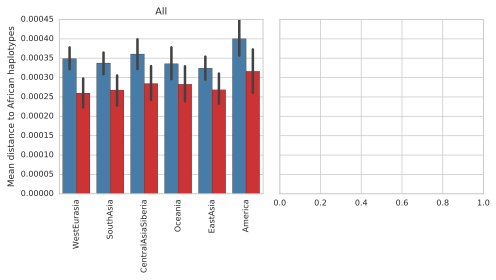

In [45]:
plot_df = (merged_data
      .loc[lambda df: (df.partial_sweep_win == True) & (df.conserv_swept_group != 'ambig')]
      .groupby(['start', 'end', 'swept', 'region_1'])['dist']
      .mean()
      .to_frame('ust_ishim_dist')
      .reset_index()
      # removing 'ambig' creates windows that does not have both swept and non-swept
      # so we need to filter to get only windows that include both calls:
      .groupby(['start', 'region_1']).filter(lambda df: set(df['swept']) == set([False, True]))
      )

plot_df['region_1'] = plot_df.region_1.cat.remove_unused_categories()

for name, group in plot_df.groupby(['region_1']):
    swept = group.sort_values(by='start').loc[lambda df: df['swept']==True, 'ust_ishim_dist']
    non_swept = group.sort_values(by='start').loc[lambda df: df['swept']==False, 'ust_ishim_dist']
    pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
    mean_reduction = numpy.mean((non_swept.values-swept.values)/non_swept.values)
    print("{:<20} pvalue: {:<10.2} corrected pvalue: {:<10.2} mean reduction: {:<10.2}".format(name, pval, pval*6, mean_reduction))

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), sharey=True)
            g1 = sns.barplot(x="region_1", y="ust_ishim_dist", hue='swept', 
                             data=plot_df, 
                             ax=ax1, n_boot=1000)
            ax1.set_ylabel('Mean distance to African haplotypes')
            ax1.set_xlabel('')
            ax1.set_title('All')
            for item in g1.get_xticklabels():
                item.set_rotation(90)
            ax1.legend_.remove()
            #ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#             g2 = sns.barplot(x="region_1", y="ust_ishim_dist", hue='swept', 
#                              data=plot_df.merge(windows_without_swept_afr, on=['start', 'end']),
#                              ax=ax2, n_boot=1000)
#             ax2.set_ylabel('Mean distance to African haplotypes')
#             ax2.set_xlabel('')
#             ax2.set_title('Without windows where an African is also swept')
#             for item in g2.get_xticklabels():
#                 item.set_rotation(90)
                
                
#             ax2.get_legend().set_title('Is swept')
#             handles, labels = ax2.get_legend_handles_labels()

#             ax2.legend(handles, ['Not swept', 'Swept'],
#                      bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.
#                      # bbox_to_anchor=(1., 1.0),  loc='upper left',
#                      # bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center', ncol=2
#                     )    
                
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'dist_to_afr_by_region.pdf' ))
            plt.savefig(str(figures_dir / 'dist_to_afr_by_region.png' ))

## Same but for admix filtered